In [224]:
#We import our packages
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the first dataset: Life expectancy at birth
We use the first csv dataset to calculate the **life expectancy** at birth in each state of USA in 2015.
We will need to clean our dataset in order to extract, from data related to the different counties, the *average life expectancy* in each state of US.

In [225]:
#We load our dataset
life_expectancy_original = pd.read_csv("Data/U.S._Life_Expectancy_at_Birth_by_State_and_Census_Tract_-_2010-2015.csv")
life_expectancy_original.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error
0,Alabama,Autauga County,201.0,73.1,56.3 - 75.0,2.2348
1,Alabama,Autauga County,202.0,76.9,75.1 - 77.4,3.3453
2,Alabama,Autauga County,204.0,75.4,75.1 - 77.4,1.0216
3,Alabama,Autauga County,205.0,79.4,77.5 - 79.4,1.1768
4,Alabama,Autauga County,206.0,73.1,56.3 - 75.0,1.5519


In [226]:
# Just a random element which has some NaN values.
life_expectancy_original.iloc[73108]

State                                 Wyoming
County                                    NaN
Census Tract Number                       NaN
Life Expectancy                          78.8
Life Expectancy Range             77.5 - 79.4
Life Expectancy Standard Error         0.0996
Name: 73108, dtype: object

We can notice how some values are missing. 
We have different situations in different rows:
1. The data for County and Census Tract are present, but not the data about life expectancy.
In this case, the problem could be linked to missing data in collecting them in different Census Tracts. We decide to ignore these data, dropping them so that they will not affect our analysis.
2. The data for County are present, with relative life expectancy, but not the related Census Tract Number.
Why? We hypotise this data could be the average value of life expectancy per county, but our source do not specify it! In the database description it is only mentioned "the life expectancy per Census Tract", not that it contained further analysis! We decide to drop them and do our analysis without them.
3. The data for State are present, with relative life expectancy, but not the related County and Census Tract Number.
Same as before!
4. Wisconsin and Maine have no data! We will need to consider these missing data!

**Attention!:** in doing this, we are probably introducing some errors, and as we will consider some approximations, if the data 2. and 3. were the hypotised ones, they probably would be more accurate! But we don't know it, so we decide to go further with our analysis and the remaining data.

In [227]:
life_expectancy_original = life_expectancy_original.dropna()
life_expectancy_original.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error
0,Alabama,Autauga County,201.0,73.1,56.3 - 75.0,2.2348
1,Alabama,Autauga County,202.0,76.9,75.1 - 77.4,3.3453
2,Alabama,Autauga County,204.0,75.4,75.1 - 77.4,1.0216
3,Alabama,Autauga County,205.0,79.4,77.5 - 79.4,1.1768
4,Alabama,Autauga County,206.0,73.1,56.3 - 75.0,1.5519


In [228]:
life_expectancy_columns = life_expectancy_original[['State','County','Census Tract Number','Life Expectancy']]
life_expectancy_columns.head()
# We drop the column about the Life Expectancy Range, as we need a precise calculation of our value 
# and not a range, while we effectuate our analysis about the average life expectancy, and do not care
# about the standard error for each Census Tract

,State,County,Census Tract Number,Life Expectancy
0,Alabama,Autauga County,201.0,73.1
1,Alabama,Autauga County,202.0,76.9
2,Alabama,Autauga County,204.0,75.4
3,Alabama,Autauga County,205.0,79.4
4,Alabama,Autauga County,206.0,73.1


### What is a census tract? (From https://en.wikipedia.org/wiki/Census_tract)
A *census tract*, census area, census district or meshblock is a geographic region defined for the purpose of taking a census. Sometimes these coincide with the limits of cities, towns or other administrative areas and several tracts commonly exist within a county. In unincorporated areas of the United States these are often arbitrary, except for coinciding with political lines.
Census tracts represent the **smallest territorial entity for which population data are available in many countries**. In the United States, census tracts are subdivided into block groups and census blocks. In Canada they are divided into dissemination areas. In the U.S., census tracts are "designed to be relatively homogeneous units with respect to population characteristics, economic status, and living conditions" and "average about 4,000 inhabitants".

### How will it be useful for our calculations?
From our dataset, we can see how different counties have different numbers of census tracts.
To calculate our value of life expectancy for each state, we should know how many people are in each census tract, and calculate the weighted average.
But we do not have this information!

*Census tracts generally contain between 1,000 and 8,000 people with an optimum size of 4,000 people. Census tract boundaries are delineated with the intention of being stable over many decades, so they generally follow relatively permanent visible features.* (From https://pitt.libguides.com/uscensus/understandinggeography)
They are made in order to be **more or less all of the same dimension!**
Calculating the average of all the census tract values should not affect that much our analysis!

In [229]:
#We group our data per state
life_expectancy_grouped = life_expectancy_columns.groupby(life_expectancy_columns.State)
life_expectancy_grouped.head()

,State,County,Census Tract Number,Life Expectancy
0,Alabama,Autauga County,201.0,73.1
1,Alabama,Autauga County,202.0,76.9
2,Alabama,Autauga County,204.0,75.4
3,Alabama,Autauga County,205.0,79.4
4,Alabama,Autauga County,206.0,73.1
...,...,...,...,...
67349,Wyoming,Albany County,9627.0,80.4
67350,Wyoming,Albany County,9628.0,82.0
67351,Wyoming,Albany County,9629.0,81.1
67352,Wyoming,Albany County,9630.0,76.8


In [230]:
#We calculate the mean 
life_expectancy = life_expectancy_grouped.mean()[['Life Expectancy']]
life_expectancy.columns=['Life_Expectancy']
life_expectancy.head()

,Life_Expectancy
State,
Alabama,74.813987
Alaska,78.915541
Arizona,78.364742
Arkansas,75.626900
California,80.231014


We manage to find data about Maine and Winconsin on this site: https://www.worldlifeexpectancy.com/usa/maine-life-expectancy
The data are related to 2014, but they can be compared to the the data about the following year, and are of course still better than a missing data!
We decide to append them to our Dataframe!

In [231]:
df1=pd.DataFrame([{'State': 'Maine', 'Life_Expectancy': 79.19},
                  {'State': 'Wisconsin', 'Life_Expectancy': 79.98}])
df1.set_index('State',inplace=True)
df1

,Life_Expectancy
State,
Maine,79.19
Wisconsin,79.98


In [232]:
life_expectancy = pd.concat([life_expectancy, df1], axis=0)
life_expectancy.head()

,Life_Expectancy
State,
Alabama,74.813987
Alaska,78.915541
Arizona,78.364742
Arkansas,75.626900
California,80.231014


In [233]:
# We reorder the dataframe sorting on the state
life_expectancy = life_expectancy.sort_values('State')
life_expectancy.head()

,Life_Expectancy
State,
Alabama,74.813987
Alaska,78.915541
Arizona,78.364742
Arkansas,75.626900
California,80.231014


We finally have the first information we need: the **life expectancy in every state of USA.**
We plot our obtained data in order to identify outliers and evaluate wheter we need to do something else.

Text(0, 0.5, 'Number of states')

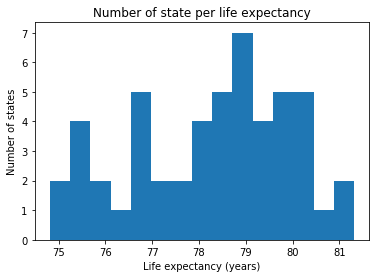

In [234]:
plt.hist(life_expectancy.Life_Expectancy, bins=15)
plt.title("Number of state per life expectancy")
plt.xlabel("Life expectancy (years)")
plt.ylabel("Number of states")

We can see how data seem to be quite homogeneous! Our work seems to be fine!

In [235]:
# We sort our data to see which state is the "Life Expectancy Champion!"
life_expectancy.sort_values('Life_Expectancy', ascending=False).head()

,Life_Expectancy
State,
Hawaii,81.314894
Vermont,81.022286
Minnesota,80.468912
Massachusetts,80.340246
New York,80.326875


In [236]:
# We sort them in ascending order (the first will be the worst)
life_expectancy.sort_values('Life_Expectancy', ascending=True).head()

,Life_Expectancy
State,
Alabama,74.813987
Mississippi,75.026941
Louisiana,75.372675
Tennessee,75.530325
Kentucky,75.564402


**Hawaii  is the life expectancy champion!** We will expect in our final analysis that this state (with other like Vermont or Minnesota) will have high rates when giving importance to the quality of life, while states like Louisiana, Mississippi or Alabama will be less rated.

## Loading the second dataset: Disposable personal income
Our second csv dataset regards the disposable personal income! Let's import it, in order to see how it is structured!

In [237]:
#We load our dataset
income_original = pd.read_csv("Data/personal_income_and_population.csv", sep=',', skiprows=4)
income_original
#We skip the first 4 rows, as they just are a description of what the dataset is about

,GeoFips,GeoName,LineCode,Description,2018
0,00000,United States*,51.0,Disposable personal income (millions of dollars),15737171.0
1,00000,United States*,52.0,Population (persons) 1/,327167434.0
2,00000,United States*,53.0,Per capita disposable personal income (dollars...,48101.0
3,01000,Alabama,51.0,Disposable personal income (millions of dollars),186791.1
4,01000,Alabama,52.0,Population (persons) 1/,4887871.0
...,...,...,...,...,...
181,1/ Census Bureau midyear population estimate. ...,NaN,NaN,NaN,NaN
182,2/ Per capita disposable personal income is to...,NaN,NaN,NaN,NaN
183,* Alaska and Hawaii are included in the U.S. a...,NaN,NaN,NaN,NaN
184,Note-- All dollar estimates are in millions of...,NaN,NaN,NaN,NaN


In [238]:
# Also the last 6 rows are just a legend of the dataset! We can drop them!
income_original = income_original.drop([180, 181, 182, 183, 184, 185])
income_original.head()

,GeoFips,GeoName,LineCode,Description,2018
0,00000,United States*,51.0,Disposable personal income (millions of dollars),15737171.0
1,00000,United States*,52.0,Population (persons) 1/,327167434.0
2,00000,United States*,53.0,Per capita disposable personal income (dollars...,48101.0
3,01000,Alabama,51.0,Disposable personal income (millions of dollars),186791.1
4,01000,Alabama,52.0,Population (persons) 1/,4887871.0


Our dataset is a **long dataframe** where each geographic region has 3 values:
1. Disposable personal income (millions of dollars) --> LineCode==51.0
2. Population --> LineCode==52.0
3. Per capita personal income (dollars) --> LineCode==53.0

We are interested in the *per capita personal income*, that is to say an individual's total earnings from wages, investment enterprises, and other ventures. We could describe it as the money every person disposes for its necessities.
However, the population of each state could probably be really useful for our analysis in the further stages of it.
We want to build a **large dataframe** where every geographic region involved has 2 parameters: Per capita personal income and population.

In [239]:
# We create a DataFrame for the personal income
personal_income = income_original[[x == 53.0 for x in income_original.LineCode]]

#We keep of this DataFrame just the informations we need, rename the columns and set the state as the index
personal_income = personal_income[['GeoName','2018']]
personal_income.columns = ['State','Per_capita_income']
personal_income.set_index('State', inplace=True)
personal_income.head()

,Per_capita_income
State,
United States*,48101.0
Alabama,38215.0
Alaska*,54430.0
Arizona,39955.0
Arkansas,39171.0


In [240]:
# We do the same for the population!
population=income_original[[x==52.0 for x in income_original.LineCode]]
population=population[['GeoName','2018']]
population.columns=['State','Population']
population.set_index('State', inplace=True)
population.head()

,Population
State,
United States*,327167434.0
Alabama,4887871.0
Alaska*,737438.0
Arizona,7171646.0
Arkansas,3013825.0


### We have now 3 DataFrame
1. **life_expectancy**
2. **personal_income**
3. **population**

All the 3 have "State" as index!
But we can notice that in the last 2 we have more geographical areas than the needed States!
Moreover, some of these geographical areas have an asterisk at the end of the name!
1. We need to solve the second problem
2. When solved, we can just perform an inner join between the first dataset and the following 2 in order to have just the States we need! In fact, life_expectancy just have our States!

In [241]:
# We start merging population and personal_income that have the same index
pop_inc = pd.merge(population, personal_income, left_index=True, right_index=True)
pop_inc.head()

,Population,Per_capita_income
State,,
United States*,327167434.0,48101.0
Alabama,4887871.0,38215.0
Alaska*,737438.0,54430.0
Arizona,7171646.0,39955.0
Arkansas,3013825.0,39171.0


In [242]:
# We remove the star character at the end of the names that have it.
pop_inc_c = pop_inc.copy()  # First we reset the index
pop_inc_c.reset_index(inplace=True)
for i, row in pop_inc_c.iterrows():
    if pop_inc_c.State[i].endswith('*'):  # if the state ends with *
        pop_inc_c.loc[i, "State"] = pop_inc_c.State[i].split("*")[0:-1]  # we just don't consider the asterisk
pop_inc = pop_inc_c 
pop_inc.head()

,State,Population,Per_capita_income
0,United States,327167434.0,48101.0
1,Alabama,4887871.0,38215.0
2,Alaska,737438.0,54430.0
3,Arizona,7171646.0,39955.0
4,Arkansas,3013825.0,39171.0


In [243]:
pop_inc.set_index('State', inplace=True)  # We reset the index to the states

# We merge the pop_inc and the life_expectancy dataset, on the index (State) column
pop_inc_exp = pd.merge(pop_inc, life_expectancy, left_index=True, right_index=True) 
pop_inc_exp.head()

,Population,Per_capita_income,Life_Expectancy
State,,,
Alabama,4887871.0,38215.0,74.813987
Alaska,737438.0,54430.0,78.915541
Arizona,7171646.0,39955.0,78.364742
Arkansas,3013825.0,39171.0,75.626900
California,39557045.0,54800.0,80.231014


In [244]:
# Let's see how the personal income goes!
pop_inc_exp.sort_values('Per_capita_income', ascending=False).head()

,Population,Per_capita_income,Life_Expectancy
State,,,
District of Columbia,702455.0,70167.0,76.407879
Connecticut,3572665.0,65063.0,80.101405
Massachusetts,6902149.0,61147.0,80.340246
New Jersey,8908520.0,59180.0,79.590645
New York,19542209.0,58005.0,80.326875


In [245]:
# And the worst ones.
pop_inc_exp.sort_values('Per_capita_income', ascending=True).head()

,Population,Per_capita_income,Life_Expectancy
State,,,
Mississippi,2986530.0,34752.0,75.026941
West Virginia,1805832.0,37061.0,75.691006
New Mexico,2095428.0,38068.0,78.546753
Kentucky,4468402.0,38075.0,75.564402
Alabama,4887871.0,38215.0,74.813987


Text(0, 0.5, 'Number of states')

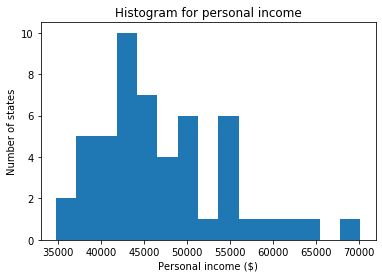

In [246]:
plt.hist(pop_inc_exp.Per_capita_income, bins=15)
plt.title("Histogram for personal income")
plt.xlabel("Personal income ($)")
plt.ylabel("Number of states")

Mississippi seems to be a again one of the worst places in US to leave, but incomes are low also in West Virginia and New Mexico. D.C., Connecticut and Massachussets are the best ranked states per personal income!

pop_inc_exp is our actual DataFrame containing information from the first 2 csv datasets. Now we need to continue adding other data. The next datasets regard the level of education of each state!

## Loading other three dataset: education field

### First dataset: colleges and universities

The colleges and university dataset is composed of all Post Secondary Education facilities as defined by the **Integrated Post Secondary Education System (IPEDS)**, National Center for Education Statistics, US Department of Education. Included are Doctoral/Research Universities, Masters Colleges and Universities, Baccalaureate Colleges, Associates Colleges, Theological seminaries, Medical Schools and other health care professions, Schools of engineering and technology, business and management, art, music, design, Law schools, Teachers colleges, Tribal colleges, and other specialized institutions.

In [247]:
#We load our dataset
colleges_universities_or = pd.read_csv("Data/Colleges_and_Universities.csv")
colleges_universities_or.head()

,X,Y,OBJECTID,IPEDSID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,ALIAS,SIZE_SET,INST_SIZE,PT_ENROLL,FT_ENROLL,TOT_ENROLL,HOUSING,DORM_CAP,TOT_EMP,SHELTER_ID
0,-115.210504,36.158505,7001,181880,ACADEMY OF HAIR DESIGN-LAS VEGAS,"5191 W. CHARLESTON, #150",LAS VEGAS,NV,89146,NOT AVAILABLE,...,NOT AVAILABLE,-2,1,-999,239,239,2,-999,23,NOT AVAILABLE
1,-115.046158,36.037585,7002,182148,ALTIERUS CAREER COLLEGE-HENDERSON,170 NORTH STEPHAINE SUITE 145,HENDERSON,NV,89074,8811,...,NOT AVAILABLE,2,1,100,172,272,2,-999,26,NOT AVAILABLE
2,-75.909212,42.135320,7003,189547,SUNY BROOME COMMUNITY COLLEGE,907 UPPER FRONT ST,BINGHAMTON,NY,13905,NOT AVAILABLE,...,NOT AVAILABLE,3,3,1549,4075,5624,1,360,819,NOT AVAILABLE
3,-78.180099,42.997351,7004,190309,CONTINENTAL SCHOOL OF BEAUTY CULTURE-BATAVIA,215 E. MAIN ST,BATAVIA,NY,14020,NOT AVAILABLE,...,NOT AVAILABLE,-2,1,-999,26,26,2,-999,3,NOT AVAILABLE
4,-77.073708,42.117240,7005,190442,CORNING COMMUNITY COLLEGE,1 ACADEMIC DR,CORNING,NY,14830,NOT AVAILABLE,...,NOT AVAILABLE,3,2,1997,1837,3834,1,270,384,NOT AVAILABLE


This dataset contains tons of data about educational institutions of USA. What can we extract form it?

- Name of each institution
- State
- NAICS code and description of each institution: in particular we have different codes!

We can extract, for each state and each type of institution, the number of institutions!

In [248]:
colleges_universities_columns = colleges_universities_or[['NAME','STATE','NAICS_CODE','NAICS_DESC']]
colleges_universities_columns.head()

,NAME,STATE,NAICS_CODE,NAICS_DESC
0,ACADEMY OF HAIR DESIGN-LAS VEGAS,NV,611511,COSMETOLOGY AND BARBER SCHOOLS
1,ALTIERUS CAREER COLLEGE-HENDERSON,NV,611210,JUNIOR COLLEGES
2,SUNY BROOME COMMUNITY COLLEGE,NY,611210,JUNIOR COLLEGES
3,CONTINENTAL SCHOOL OF BEAUTY CULTURE-BATAVIA,NY,611511,COSMETOLOGY AND BARBER SCHOOLS
4,CORNING COMMUNITY COLLEGE,NY,611210,JUNIOR COLLEGES


We can see different NAICS code for different institutions; in particular we have:

- 611310: colleges, universities and professional schools
- 611210: junior colleges
- 611511/611519: cosmetology, technical, trade schools

In [249]:
# We calculate how many colleges, universities and professional schools are there in each state
colleges_universities_grouped = colleges_universities_columns[[x == 611310 for x in colleges_universities_columns.NAICS_CODE]].groupby('STATE')
colleges_universities = colleges_universities_grouped.count()[['NAME']]
colleges_universities.columns = ['N_of_colleges_universities']
colleges_universities.head()

,N_of_colleges_universities
STATE,
AK,6
AL,42
AR,26
AZ,46
CA,264


In [250]:
# We do the same for junior colleges...
junior_colleges_grouped = colleges_universities_columns[[x == 611210 for x in colleges_universities_columns.NAICS_CODE]].groupby('STATE')
junior_colleges = junior_colleges_grouped.count()[['NAME']]
junior_colleges.columns = ['N_of_junior_colleges']
junior_colleges.head()

,N_of_junior_colleges
STATE,
AK,1
AL,36
AR,26
AS,1
AZ,43


In [251]:
#... and trade and technical schools
technical_schools_grouped = colleges_universities_columns[
    [x == 611511 or x == 611519 for x in colleges_universities_columns.NAICS_CODE]
].groupby('STATE')
technical_schools = technical_schools_grouped.count()[['NAME']]
technical_schools.columns = ['N_of_technical_trade_schools']
technical_schools.head()

,N_of_technical_trade_schools
STATE,
AK,2
AL,16
AR,32
AZ,42
CA,239


In [252]:
# Now we merge the obtained informations
number_of_institutions1 = pd.merge(colleges_universities, junior_colleges, left_index=True, right_index=True, how='outer')
number_of_institutions = pd.merge(number_of_institutions1, technical_schools, left_index=True, right_index=True, how='outer')
number_of_institutions.head()

,N_of_colleges_universities,N_of_junior_colleges,N_of_technical_trade_schools
STATE,,,
AK,6.0,1.0,2.0
AL,42.0,36.0,16.0
AR,26.0,26.0,32.0
AS,NaN,1.0,NaN
AZ,46.0,43.0,42.0


In [253]:
# The NaN are present if there is no count of that kind of school in that state! We need to
# substitute them with 0
number_of_institutions = number_of_institutions.fillna(0)
number_of_institutions.head()

,N_of_colleges_universities,N_of_junior_colleges,N_of_technical_trade_schools
STATE,,,
AK,6.0,1.0,2.0
AL,42.0,36.0,16.0
AR,26.0,26.0,32.0
AS,0.0,1.0,0.0
AZ,46.0,43.0,42.0


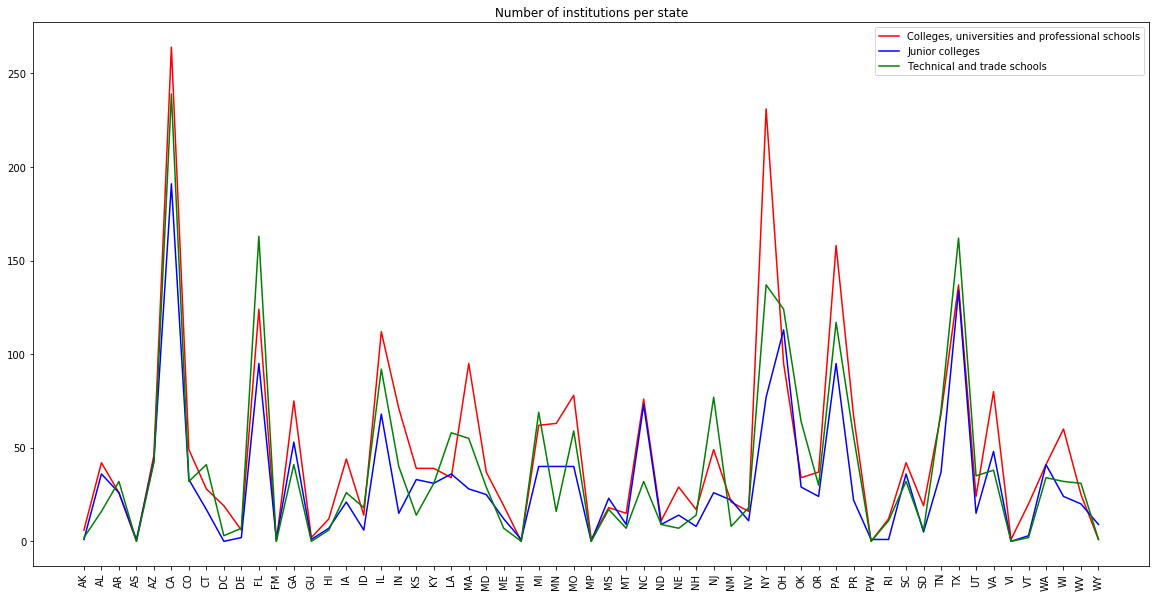

In [254]:
# We plot the informations obtained
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.title("Number of institutions per state")
plt.plot(number_of_institutions.index, number_of_institutions.N_of_colleges_universities, 'r') 
plt.plot(number_of_institutions.index, number_of_institutions.N_of_junior_colleges, 'b') 
plt.plot(number_of_institutions.index, number_of_institutions.N_of_technical_trade_schools, 'g') 
plt.gca().legend(('Colleges, universities and professional schools', 'Junior colleges', 'Technical and trade schools'))

### Second dataset: colleges and universities' details

The second dataset we have gives us a deep insight of colleges and universities!
In this dataset we have lots of informations about the listed institutions!
Let's see what we can obtain from it!

In [255]:
institutions_or = pd.read_excel("Data/cc_institution_details.xlsx", skiprows=1)
institutions_or.head()

,unitid,chronname,city,state,level,control,basic,hbcu,flagship,long_x,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,-86.568502,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,-86.809170,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,-86.174010,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,-86.638420,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,-86.295677,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


We can see some columns that collect "efficiency measures", as reported by the dataset description.

**Awards per 100 full-time undergraduate students** includes all undergraduate-level completions reported by the institution to the NCES: bachelor’s degrees, associate degrees, and certificate programs of less than four years in length. Full-time-equivalent undergraduates are estimated from the number of credit hours taken at the institution in an academic year. To account for changes in enrollment, the resulting metric is a three-year average of data from 2011, 2012, and 2013.

**Expenditure categories** are slightly different depending on whether the institution is public, private non-profit, or private for-profit. The spending types considered to be educational in nature, either directly or indirectly, are: instruction, research, public service, student services, academic support, institutional support, operations, and maintenance. Because separate spending figures are not available for only undergraduate students, the measure includes graduate degrees, post-master’s certificates, and all doctorates.

Let's use these measures to evaluate the level of the universities of each state!

In [256]:
institutions_columns = institutions_or[['chronname', 'state', 'awards_per_value', 'exp_award_value']]
institutions_columns.head()

,chronname,state,awards_per_value,exp_award_value
0,Alabama A&M University,Alabama,14.2,105331
1,University of Alabama at Birmingham,Alabama,20.9,136546
2,Amridge University,Alabama,29.9,58414
3,University of Alabama at Huntsville,Alabama,20.9,64418
4,Alabama State University,Alabama,11.6,132407


We can now calculate, for each state, the mean of these two values.
States with a better level of education should have both indexes high, in fact:
- high award index underlines the efficiency of each institution to lead its students to a successful completion of the studies;
- high expenditure levels mean (or at least should mean) a higher level of the listed educational services!

In [257]:
institutions_grouped = institutions_columns.groupby('state')
institutions_levels = institutions_grouped.mean()[['awards_per_value','exp_award_value']]
institutions_levels.head()

,awards_per_value,exp_award_value
state,,
Alabama,19.514493,63013.173913
Alaska,18.414286,141431.142857
Arizona,25.563492,47830.888889
Arkansas,21.970833,51132.479167
California,22.771429,63022.202857


Text(0, 0.5, 'awards per 100 full time students')

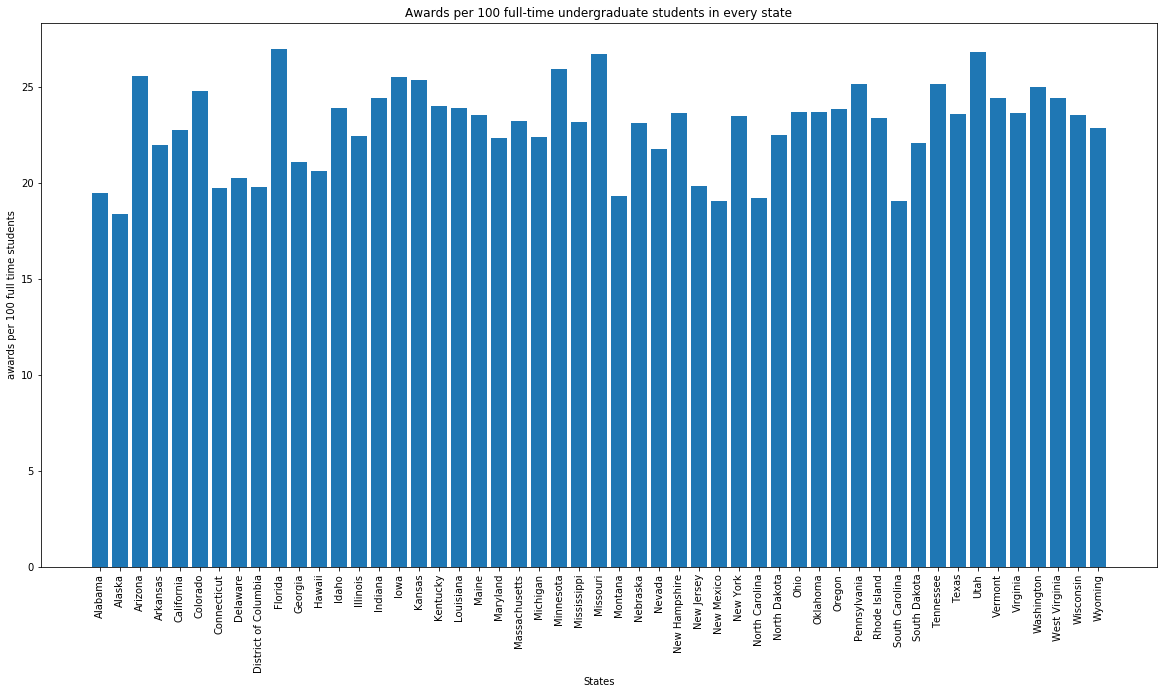

In [258]:
#We plot the informations obtained
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.title("Awards per 100 full-time undergraduate students in every state")
plt.bar(institutions_levels.index, institutions_levels.awards_per_value)
plt.xlabel("States")
plt.ylabel("awards per 100 full time students")

Text(0, 0.5, 'Expenditure ($) per each award')

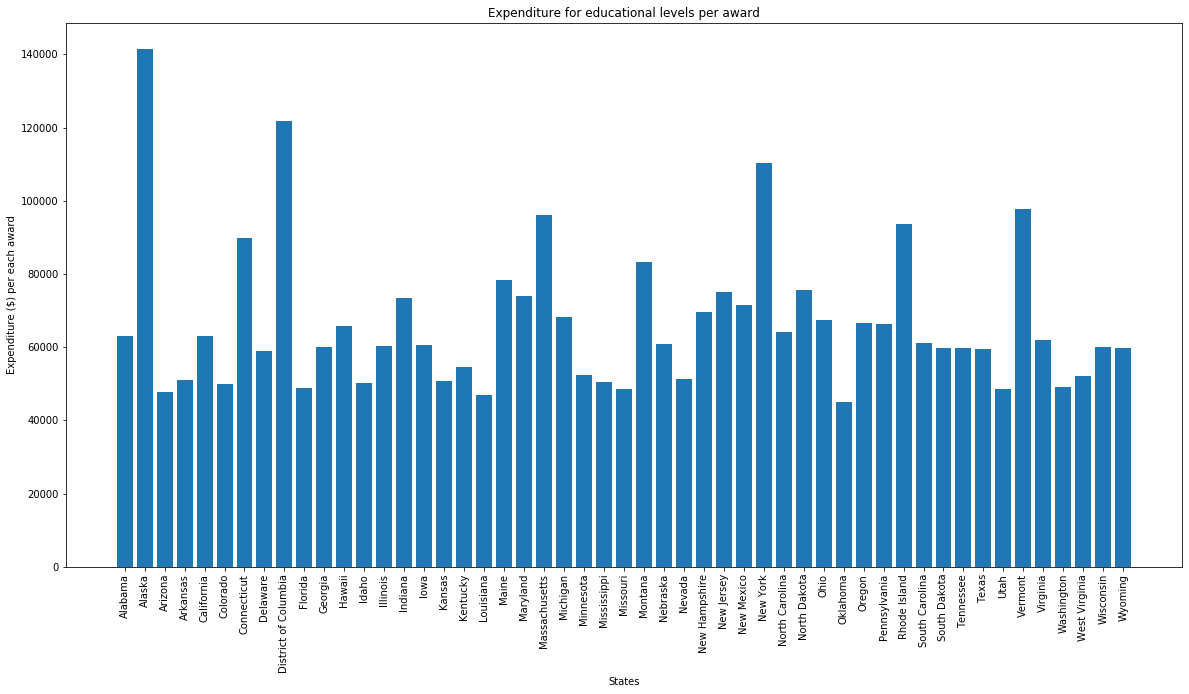

In [259]:
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.bar(institutions_levels.index, institutions_levels.exp_award_value)
plt.title(('Expenditure for educational levels per award'))
plt.xlabel("States")
plt.ylabel("Expenditure ($) per each award")

### Third dataset: university ranking

Our third dataset reports the first 230 universities in US. Let's take a look!

In [260]:
univ_ranking_or = pd.read_excel("Data/National_University_Ranking.xlsx", skiprows=1)
univ_ranking_or.head()

,Name,Location,Rank,Description,Tuition and fees,In-state,Undergrad Enrollment
0,Princeton University,"Princeton, NJ",1,"Princeton, the fourth-oldest college in the Un...","$45,320",NaN,5.402
1,Harvard University,"Cambridge, MA",2,"Harvard is located in Cambridge, Massachusetts...","$47,074",NaN,6.699
2,University of Chicago,"Chicago, IL",3,"The University of Chicago, situated in Chicago...","$52,491",NaN,5.844
3,Yale University,"New Haven, CT",3,"Yale University, located in New Haven, Connect...","$49,480",NaN,5.532
4,Columbia University,"New York, NY",5,"Columbia University, located in Manhattan's Mo...","$55,056",NaN,6.102


We can use this dataset to calculate how many top universities are there in each state, and how high are they ranked.
For example, we could attribute the highest value to the best ranked university and so on!
Let's process our dataset to evaluate this!

In [261]:
# We use just the columns we need
univ_ranking_columns = univ_ranking_or[['Name', 'Location', 'Rank']]
univ_ranking_columns.head()

,Name,Location,Rank
0,Princeton University,"Princeton, NJ",1
1,Harvard University,"Cambridge, MA",2
2,University of Chicago,"Chicago, IL",3
3,Yale University,"New Haven, CT",3
4,Columbia University,"New York, NY",5


In [262]:
#We explode the "Location" column to calculate the state
univ_state = pd.Series([])
univ_state_col = univ_ranking_columns.Location
for i in range(0, 231):
    univ_state[i] = univ_state_col[i][-2:]
univ_state.name = ('State')
univ_state.head()

0    NJ
1    MA
2    IL
3    CT
4    NY
Name: State, dtype: object

In [263]:
#Now we add the column to the dataframe
ranking_columns_xy = univ_ranking_columns.merge(univ_state, left_index=True, right_index=True)
ranking_columns_xy.head()

,Name,Location,Rank,State
0,Princeton University,"Princeton, NJ",1,NJ
1,Harvard University,"Cambridge, MA",2,MA
2,University of Chicago,"Chicago, IL",3,IL
3,Yale University,"New Haven, CT",3,CT
4,Columbia University,"New York, NY",5,NY


In [264]:
# We use the right column and rename it, and leave the Tuition_and_fees column without the dollar sign
ranking_columns_state = ranking_columns_xy[['State', 'Name', 'Rank']]
ranking_columns_state.head()

,State,Name,Rank
0,NJ,Princeton University,1
1,MA,Harvard University,2
2,IL,University of Chicago,3
3,CT,Yale University,3
4,NY,Columbia University,5


In [265]:
# We calculate a column with a "ranking value": as the ranked universities are 230, we can calculate
# the points for each university in the following way
ranking_point = pd.Series([])
for i in range(0,231):
    # We assign a higher score to universities which are higher in the standings.
    ranking_point[i] = (231 - ranking_columns_state.Rank[i])  
ranking_point.name = 'Ranking_points'
ranking_point

0      230
1      229
2      228
3      228
4      226
      ... 
226     11
227     11
228     11
229     11
230     11
Name: Ranking_points, Length: 231, dtype: int64

In [266]:
# Now we add the column to the dataframe
ranking_columns = ranking_columns_state.merge(ranking_point, left_index=True, right_index=True)
ranking_columns.head()

,State,Name,Rank,Ranking_points
0,NJ,Princeton University,1,230
1,MA,Harvard University,2,229
2,IL,University of Chicago,3,228
3,CT,Yale University,3,228
4,NY,Columbia University,5,226


At this point, we can calculate for each state:
- **top_230_state_score**: for each state, cumulative ranking points, so that we take into how account how many top universities are there in each state, and how "top" they are.

In [267]:
# We group our data by State
ranking_grouped = ranking_columns.groupby('State')

In [268]:
#We calculate the top_230_ranking_score
ranking_score = ranking_grouped.sum()[['Ranking_points']]  # We sum the scores related to the same states.
ranking_score.columns = ['top_230_ranking_score']
ranking_score.head()

,top_230_ranking_score
State,
AK,29
AL,366
AR,96
AZ,209
CA,3064


Text(0, 0.5, 'Top 230 score')

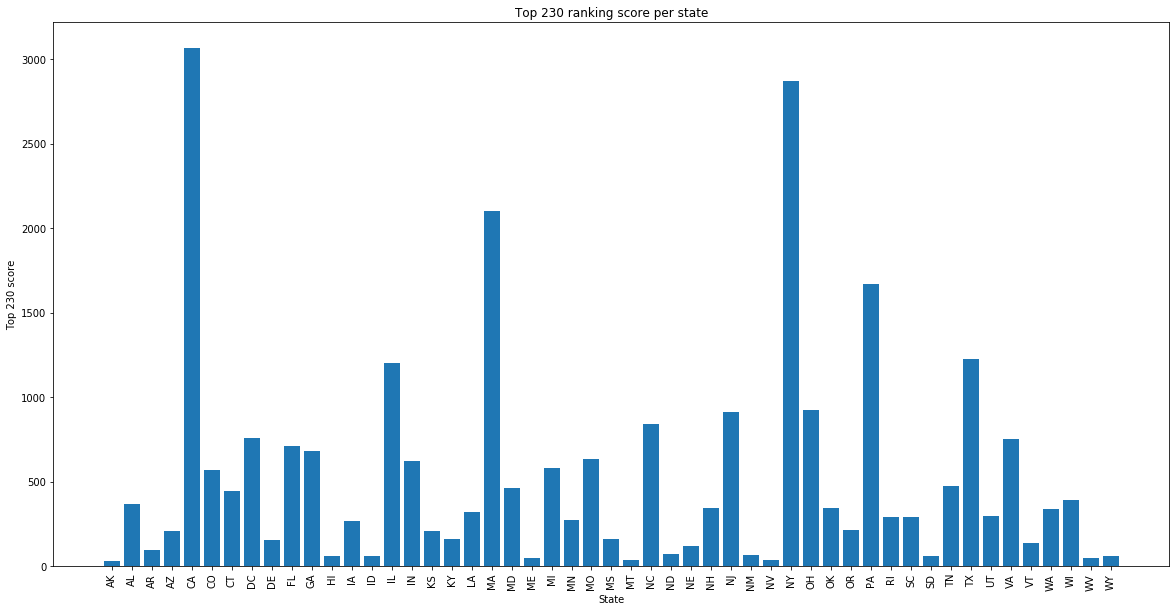

In [269]:
#We plot our result
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.bar(ranking_score.index, ranking_score.top_230_ranking_score)
plt.title(('Top 230 ranking score per state'))
plt.xlabel("State")
plt.ylabel("Top 230 score")

Now we have 3 dataset about education:
- number_of_institutions
- institutions_levels
- ranking_score
We can merge it in order to obtain a final dataset about education!

But there is a problem!
- number_of_institutions and ranking_score have the state as a code
- institutions_level has the full name of the state!

In [270]:
# We import the csv that collects states and abbreviation
abbreviation = pd.read_csv("Data/state-abbrevs.csv")
abbreviation.head()

,state,abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [271]:
# We merge this dataframe with the institutions_level one
education1 = institutions_levels.merge(abbreviation, left_index=True, right_on=abbreviation.state, how='inner')
education2 = education1.pop('key_0')  # We pop the 'key_0' column
education1.head()

,awards_per_value,exp_award_value,state,abbreviation
0,19.514493,63013.173913,Alabama,AL
1,18.414286,141431.142857,Alaska,AK
2,25.563492,47830.888889,Arizona,AZ
3,21.970833,51132.479167,Arkansas,AR
4,22.771429,63022.202857,California,CA


In [272]:
# Now we merge the other 2 dataframes
education3 = education1.merge(number_of_institutions, left_on=education1.abbreviation, right_index=True)
education4 = education3.pop('key_0')  # We pop the 'key_0' column
education3.head()

,awards_per_value,exp_award_value,state,abbreviation,N_of_colleges_universities,N_of_junior_colleges,N_of_technical_trade_schools
0,19.514493,63013.173913,Alabama,AL,42.0,36.0,16.0
1,18.414286,141431.142857,Alaska,AK,6.0,1.0,2.0
2,25.563492,47830.888889,Arizona,AZ,46.0,43.0,42.0
3,21.970833,51132.479167,Arkansas,AR,26.0,26.0,32.0
4,22.771429,63022.202857,California,CA,264.0,191.0,239.0


In [273]:
education5 = education3.merge(ranking_score, left_on=education3.abbreviation, right_index=True)
education6 = education5.pop('key_0')
education5.head()

,awards_per_value,exp_award_value,state,abbreviation,N_of_colleges_universities,N_of_junior_colleges,N_of_technical_trade_schools,top_230_ranking_score
0,19.514493,63013.173913,Alabama,AL,42.0,36.0,16.0,366
1,18.414286,141431.142857,Alaska,AK,6.0,1.0,2.0,29
2,25.563492,47830.888889,Arizona,AZ,46.0,43.0,42.0,209
3,21.970833,51132.479167,Arkansas,AR,26.0,26.0,32.0,96
4,22.771429,63022.202857,California,CA,264.0,191.0,239.0,3064


In [274]:
# We select only the important features (not the abbreviations)
education = education5[['state', 'N_of_colleges_universities', 'N_of_junior_colleges', 'N_of_technical_trade_schools',
                      'awards_per_value', 'exp_award_value', 'top_230_ranking_score']]
education.head()

,state,N_of_colleges_universities,N_of_junior_colleges,N_of_technical_trade_schools,awards_per_value,exp_award_value,top_230_ranking_score
0,Alabama,42.0,36.0,16.0,19.514493,63013.173913,366
1,Alaska,6.0,1.0,2.0,18.414286,141431.142857,29
2,Arizona,46.0,43.0,42.0,25.563492,47830.888889,209
3,Arkansas,26.0,26.0,32.0,21.970833,51132.479167,96
4,California,264.0,191.0,239.0,22.771429,63022.202857,3064


In [275]:
education.set_index('state',inplace=True)
education.head()

,N_of_colleges_universities,N_of_junior_colleges,N_of_technical_trade_schools,awards_per_value,exp_award_value,top_230_ranking_score
state,,,,,,
Alabama,42.0,36.0,16.0,19.514493,63013.173913,366
Alaska,6.0,1.0,2.0,18.414286,141431.142857,29
Arizona,46.0,43.0,42.0,25.563492,47830.888889,209
Arkansas,26.0,26.0,32.0,21.970833,51132.479167,96
California,264.0,191.0,239.0,22.771429,63022.202857,3064


In [276]:
# We can finally merge our dataset about education with the one about life expectancy and income
pop_inc_exp_edu = pop_inc_exp.merge(education, left_index=True, right_index=True)
pop_inc_exp_edu.head()

,Population,Per_capita_income,Life_Expectancy,N_of_colleges_universities,N_of_junior_colleges,N_of_technical_trade_schools,awards_per_value,exp_award_value,top_230_ranking_score
State,,,,,,,,,
Alabama,4887871.0,38215.0,74.813987,42.0,36.0,16.0,19.514493,63013.173913,366
Alaska,737438.0,54430.0,78.915541,6.0,1.0,2.0,18.414286,141431.142857,29
Arizona,7171646.0,39955.0,78.364742,46.0,43.0,42.0,25.563492,47830.888889,209
Arkansas,3013825.0,39171.0,75.626900,26.0,26.0,32.0,21.970833,51132.479167,96
California,39557045.0,54800.0,80.231014,264.0,191.0,239.0,22.771429,63022.202857,3064


## Save the pickle file
We can finally save the pickle file.

In [277]:
pop_inc_exp_edu.reset_index(inplace=True)  # Convert the index into the column State
pop_inc_exp_edu.to_pickle("Pickles/pop_inc_exp_edu.pickle")